### LIBRARIES

In [1]:
import pandas as pd
import numpy as np

from scipy.optimize import linprog

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline
import matplotlib.pyplot as plt

### METHODS

In [2]:
def get_vote(expert_votes, crowd_votes, lambda_expert, lambda_crowd):
    # GOAL FUNCTION
    w_expert = np.repeat(lambda_expert/len(expert_votes), len(expert_votes))
    w_crowd = np.repeat(lambda_crowd/len(crowd_votes), len(crowd_votes))
    w_grade = np.array([0])
    
    w = np.concatenate([w_expert, w_crowd, w_grade])
    
    # ABSOLUTE CONSTRAINTS - EXPERT
    lhs_ineq_expert_ind = (len(w_expert), len(w))
    lhs_ineq_expert_1 = np.zeros(lhs_ineq_expert_ind)
    lhs_ineq_expert_2 = np.zeros(lhs_ineq_expert_ind)
    
    rhs_ineq_expert_1 = expert_votes
    rhs_ineq_expert_2 = -expert_votes
    
    for i in range(lhs_ineq_expert_1.shape[0]):
        lhs_ineq_expert_1[i, i] = -1
        lhs_ineq_expert_1[i, len(w) - 1] = 1
        
        lhs_ineq_expert_2[i, i] = -1
        lhs_ineq_expert_2[i, len(w) - 1] = -1
   
    # ABSOLUTE CONSTRAINTS - CROWD
    lhs_ineq_crowd_ind = (len(w_crowd), len(w))
    lhs_ineq_crowd_1 = np.zeros(lhs_ineq_crowd_ind)
    lhs_ineq_crowd_2 = np.zeros(lhs_ineq_crowd_ind)
    
    rhs_ineq_crowd_1 = crowd_votes
    rhs_ineq_crowd_2 = -crowd_votes
    
    for i in range(lhs_ineq_crowd_1.shape[0]):
        lhs_ineq_crowd_1[i, len(expert_votes) + i] = -1
        lhs_ineq_crowd_1[i, len(w) - 1] = 1
        
        lhs_ineq_crowd_2[i, len(expert_votes) + i] = -1
        lhs_ineq_crowd_2[i, len(w) - 1] = -1
        
    # COMPILE
    lhs_ineq = np.concatenate((lhs_ineq_expert_1, lhs_ineq_expert_2, lhs_ineq_crowd_1, lhs_ineq_crowd_2))
    rhs_ineq = np.concatenate((rhs_ineq_expert_1, rhs_ineq_expert_2, rhs_ineq_crowd_1, rhs_ineq_crowd_2))
    
#     bnd = [(1, 5)] * len(w)
    
#     opt = linprog(c=w, A_ub=lhs_ineq, b_ub=rhs_ineq, bounds=bnd, method='interior-point')
    opt = linprog(c=w, A_ub=lhs_ineq, b_ub=rhs_ineq, method='interior-point')
    
    return opt.x[len(w) - 1]

In [3]:
def nash_bargaining_solution(expert_satisfaction, crowd_satisfaction):
    lambda_importance = crowd_satisfaction/(crowd_satisfaction + expert_satisfaction)
#     lambda_importance = 1/(1 + expert_satisfaction)

    return lambda_importance

def kalai_smorodinsky_solution(expert_s_1, crowd_s_1, expert_s_2, crowd_s_2):
    max_expert = np.max([expert_s_1, expert_s_2])
    max_crowd = np.max([crowd_s_1, crowd_s_2])
    
    lambda_importance = (max_expert * crowd_s_2 - max_crowd * expert_s_2)/(max_crowd * (expert_s_1 - expert_s_2) - max_expert * (crowd_s_1 - crowd_s_2))
    
    
    return lambda_importance

In [4]:
def expectation_maximization_nash(expert_votes, crowd_votes, num_iter = 100, verbose = False):
    lambda_expert = 0.5
    to_continue = True
    iterator = 1
    
    while to_continue:
        # FIND VOTE
        vote = get_vote(expert_votes, crowd_votes, lambda_expert = lambda_expert, lambda_crowd = (1 - lambda_expert))
    
        # FIND LAMBDA
        expert_satisfaction = np.mean(5 - np.abs(expert_votes - vote))
        crowd_satisfaction = np.mean(5 - np.abs(crowd_votes - vote))
    
        new_lambda = nash_bargaining_solution(expert_satisfaction, crowd_satisfaction)
        
        if verbose:
            print(new_lambda)
        
        # STOP CRITERIA
        if lambda_expert == new_lambda:
            to_continue = False
        else:
            lambda_expert = new_lambda
            
        iterator = iterator + 1
        if iterator == num_iter:
            to_continue = False
    
    return lambda_expert, vote, expert_satisfaction * crowd_satisfaction

def maximization_kalai_smorodinsky(expert_votes, crowd_votes):
    # FIND VOTE
    vote_1 = get_vote(expert_votes, crowd_votes, lambda_expert = 1, lambda_crowd = 0)
    vote_2 = get_vote(expert_votes, crowd_votes, lambda_expert = 0, lambda_crowd = 1)
    
    # FIND LAMBDA
    expert_s_1 = np.mean(5 - np.abs(expert_votes - vote_1))
    expert_s_2 = np.mean(5 - np.abs(expert_votes - vote_2))
    crowd_s_1 = np.mean(5 - np.abs(crowd_votes - vote_1))
    crowd_s_2 = np.mean(5 - np.abs(crowd_votes - vote_2))
    
    lambda_expert = kalai_smorodinsky_solution(expert_s_1, crowd_s_1, expert_s_2, crowd_s_2)
    
    vote = get_vote(expert_votes, crowd_votes, lambda_expert, 1 - lambda_expert)
    
    expert_satisfaction = np.mean(5 - np.abs(expert_votes - vote))
    crowd_satisfaction = np.mean(5 - np.abs(crowd_votes - vote))
    
    return lambda_expert, vote, expert_satisfaction * crowd_satisfaction

def expectation_maximization_kalai_smorodinsky(expert_votes, crowd_votes, num_iter = 100, decay = 0.1, verbose = False):
    lambda_expert = 0.5
    to_continue = True
    iterator = 1
    
    while to_continue:
        # FIND VOTE
        decay_factor = decay * (iterator - 1)/num_iter
        vote_1 = get_vote(expert_votes, crowd_votes, lambda_expert = 1 - decay_factor, lambda_crowd = 0 + decay_factor)
        vote_2 = get_vote(expert_votes, crowd_votes, lambda_expert = 0 + decay_factor, lambda_crowd = 1 - decay_factor)
    
        # FIND LAMBDA
        expert_s_1 = np.mean(5 - np.abs(expert_votes - vote_1))
        expert_s_2 = np.mean(5 - np.abs(expert_votes - vote_2))
        crowd_s_1 = np.mean(5 - np.abs(crowd_votes - vote_1))
        crowd_s_2 = np.mean(5 - np.abs(crowd_votes - vote_2))
    
        new_lambda = kalai_smorodinsky_solution(expert_s_1, crowd_s_1, expert_s_2, crowd_s_2)
        
        if verbose:
            print(new_lambda)
        
        # STOP CRITERIA
        if lambda_expert == new_lambda:
            to_continue = False
        else:
            lambda_expert = new_lambda
            
        vote = get_vote(expert_votes, crowd_votes, lambda_expert, 1 - lambda_expert)
    
        expert_satisfaction = np.mean(5 - np.abs(expert_votes - vote))
        crowd_satisfaction = np.mean(5 - np.abs(crowd_votes - vote))
            
        iterator = iterator + 1
        if iterator == num_iter:
            to_continue = False
    
    return lambda_expert, vote, expert_satisfaction * crowd_satisfaction

### EXAMPLE

In [5]:
expert_votes = np.array([5, 5])
crowd_votes = np.array([1, 1, 1, 1, 1, 1])

In [6]:
lambda_expert = 0.5
lambda_crowd = 0.5

vote_fixed = get_vote(expert_votes, crowd_votes, lambda_expert, lambda_crowd)
print(vote_fixed)

2.0610086186788226


In [10]:
expert_satisfaction_fixed = np.mean(5 - np.abs(expert_votes - vote_fixed))
crowd_satisfaction_fixed = np.mean(5 - np.abs(crowd_votes - vote_fixed))

print(expert_satisfaction_fixed, crowd_satisfaction_fixed, expert_satisfaction_fixed * crowd_satisfaction_fixed)

2.0610086186788226 3.9389913813211774 8.118295185804547


In [11]:
print(nash_bargaining_solution(expert_satisfaction_fixed, crowd_satisfaction_fixed))

0.6564985635535295


In [12]:
results = expectation_maximization_nash(expert_votes, crowd_votes, verbose=False)
results

(0.8333333232541177, 1.0000000604752943, 5.000000241901173)

In [13]:
results = maximization_kalai_smorodinsky(expert_votes, crowd_votes)
results

(0.49999999999978667, 2.061008609941568, 8.118295169396134)

In [14]:
results = expectation_maximization_kalai_smorodinsky(expert_votes, crowd_votes, verbose=False)
results

(0.5000000000341369, 2.061010016672035, 8.118297811209747)

### Pareto Front

In [11]:
expert_votes = np.array([5, 5, 5, 5])
crowd_votes = np.array([1, 2, 2, 1, 3, 1, 2, 3, 2, 2, 4, 1])

results = []

for i in range(100):
    vote = get_vote(expert_votes, crowd_votes, i/100, 1 - i/100)
    
    expert_satisfaction = np.mean(5 - np.abs(expert_votes - vote))
    crowd_satisfaction = np.mean(5 - np.abs(crowd_votes - vote))
    
    results.append([i/100, vote, expert_satisfaction, crowd_satisfaction])
    
results = pd.DataFrame(results, columns=['Dot', 'Vote', 'Expert', 'Crowd'])

In [12]:
nash_bargaining_solution(expert_satisfaction, crowd_satisfaction)

0.2857142857155079

In [13]:
maximization_kalai_smorodinsky(expert_votes, crowd_votes)

(0.5270270268329383, 4.999999979270031, 10.000000062189908)

In [14]:
expectation_maximization_nash(expert_votes, crowd_votes, verbose=False)

(0.28571428571773, 4.9999999999758895, 10.00000000007233)

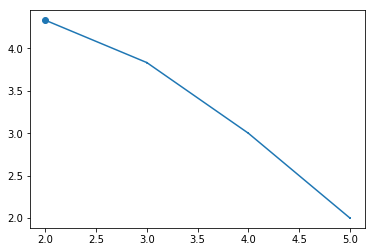

In [15]:
plt.plot(results['Expert'], results['Crowd'], markevery=[28], marker='o')

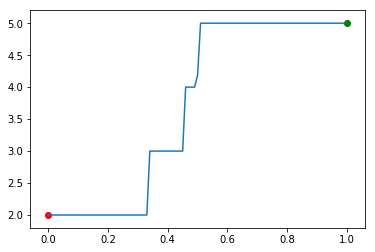

In [16]:
plt.plot(results['Dot'], results['Vote'])
plt.scatter(x=0, y=np.mean(crowd_votes), c='r')
plt.scatter(x=1, y=np.mean(expert_votes), c='g')